This workbook will create a plot of validator weights for any subnet for a given period of time
to run this workbook
1. in the first cell update api_key, days and netuid

cell 2 - time fix
cell 3 - claculates the block start and block end 
cell 4 - runs the API call and collects the data
cell 5 - defindes the plotting
cell 6  - creates the plot

In [46]:
import requests, json
import pandas as pd
import numpy as np
import decimal
import time
from datetime import datetime, timedelta
from rich import print
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

api_key=""
days =60
subnet = 19


headers = {
            "accept": "application/json",
            "Authorization": api_key
        }

In [47]:
#sometimes the chain spits out a time with milliseconds.. Sometimess it doesnt.  Its annoying.
#this fixes it. returns a datetime object
def stupid_time_fix(timestamp):
    if len(timestamp) > 20:
        date_obj = datetime.strptime(timestamp, "%Y-%m-%dT%H:%M:%S.%fZ")
    else:
        date_obj = datetime.strptime(timestamp, "%Y-%m-%dT%H:%M:%SZ")
    
    return date_obj
    

In [48]:
blocks_back =days*7200

#get current block
block_url = "https://api.taostats.io/api/block/v1?limit=1"
block_response = requests.get(block_url, headers=headers)
block_resJson = json.loads(block_response.text)
block_end = block_resJson['data'][0]['block_number']
block_start = block_end -blocks_back
print(block_start, block_end)

4236561 4668561

In [49]:
import requests
subnet_weight_data={}
page =1
total_pages = 2
while page<= total_pages:
    url = f"https://api.taostats.io/api/metagraph/root/history/v1?block_start={block_start}&block_end={block_end}&page={page}&limit=200"
    response = requests.get(url, headers=headers)
    resJson = json.loads(response.text)
    page +=1
    total_pages = resJson['pagination']['total_pages']
    valiData = resJson['data']
    for vali in valiData:
        hk = vali['hotkey']['ss58']
        #timestampe to YYYY-MM-DD
        time = stupid_time_fix(vali['timestamp'])
        date = time.strftime('%Y-%m-%d')
        weights = vali['subnet_weights']
        stake = float(vali['stake'])/1e9
        for index, value in weights.items():
            netuid = int(index)
            weight = float(value)
            if netuid not in subnet_weight_data:
                subnet_weight_data[netuid]={}
            if date not in subnet_weight_data[netuid]:
                subnet_weight_data[netuid][date] = []
            if weight >0 and stake > 1024:
                subnet_weight_data[netuid][date].append({"hotkey":hk, "weight":weight})

            
        

In [50]:
def plot_netuid(netuid):
    data = subnet_weight_data[netuid]

    # Flatten data into a list of dictionaries
    data_list = [(date, item['hotkey'], item['weight']) for date, items in data.items() for item in items]
    
    # Create a DataFrame
    df = pd.DataFrame(data_list, columns=['date', 'hotkey', 'weight'])
    
    # Convert date column to datetime
    df['date'] = pd.to_datetime(df['date'])
    
    # Pivot DataFrame to have hotkeys as columns, using mean to aggregate duplicates
    df_pivot = pd.pivot_table(df, index='date', columns='hotkey', values='weight', aggfunc='mean')
    
    # Plot
    df_pivot.plot(figsize=(12, 6))
    plt.title(f'Hotkey Weights Over Time: Subnet {netuid}')
    plt.xlabel('Date')
    plt.ylabel('Weight')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()
            

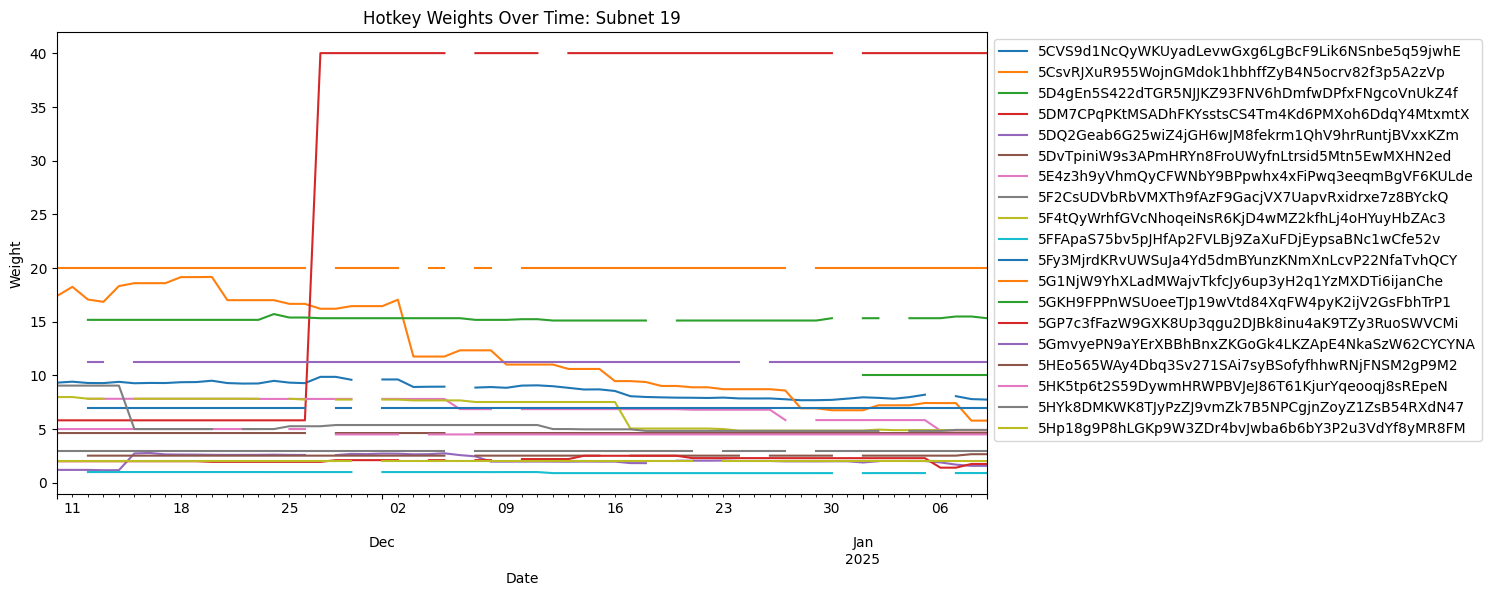

In [52]:
plot_netuid(subnet)